# World Happiness Report 2015–2019 Analysis
This notebook explores how global happiness has evolved across five years of World Happiness Report data. We focus on comparing countries and regions, uncovering drivers of happiness, and highlighting notable shifts in well-being around the world.

**Research questions**
- How do global happiness scores change from 2015 to 2019?
- Which countries improved or declined the most across the five-year span?
- How do regions and continents differ in their happiness trajectories?
- Which factors show the strongest relationships with happiness over time?

In [52]:
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


## 1. Load, normalize and merge data
We load all yearly CSV files, harmonize their schemas, and combine them into a unified dataset with consistent country and region labels. Cleaning includes standardizing column names, resolving naming differences across years, and enriching each record with region and continent metadata.

### 1.1 Configuration and Metadata
Define file paths and load metadata mappings from CSV files. These mappings harmonize column names across years, standardize country names, and provide region-to-continent relationships.

In [53]:
# File paths and metadata loading
DATA_DIR = Path("raw_data")
METADATA_DIR = Path("metadata")
PROCESSED_DIR = Path("processed_data")

YEAR_FILES = {
    2015: DATA_DIR / "2015.csv",
    2016: DATA_DIR / "2016.csv",
    2017: DATA_DIR / "2017.csv",
    2018: DATA_DIR / "2018.csv",
    2019: DATA_DIR / "2019.csv",
}

# Helper functions for loading metadata
def load_simple_mapping(csv_path: Path, key_col: str, value_col: str) -> dict:
    """Load a simple two-column mapping from CSV."""
    df = pd.read_csv(csv_path)
    return dict(zip(df[key_col], df[value_col]))

def load_column_normalization(csv_path: Path) -> dict:
    """Load column normalization mappings from CSV, grouped by year."""
    df = pd.read_csv(csv_path)
    return df.groupby("year").apply(
        lambda g: dict(zip(g["original"], g["normalized"])), 
        include_groups=False # type: ignore
    ).to_dict() # type: ignore

# Load all metadata from CSV files
COLUMN_NORMALIZATION = load_column_normalization(METADATA_DIR / "column_normalization.csv")
COUNTRY_ALIASES = load_simple_mapping(METADATA_DIR / "country_aliases.csv", "original", "alias")
REGION_OVERRIDES = load_simple_mapping(METADATA_DIR / "region_overrides.csv", "country", "region")
CONTINENT_OVERRIDES = load_simple_mapping(METADATA_DIR / "continent_overrides.csv", "country", "continent")
REGION_TO_CONTINENT = load_simple_mapping(METADATA_DIR / "region_to_continent.csv", "region", "continent")



### 1.2 Data Processing Pipeline
Load, clean, and merge data from all years. The pipeline normalizes column names, standardizes country and region labels, enriches with continent information from multiple sources, and saves the processed dataset for downstream analysis.

In [ ]:
def harmonize_year(year: int, path: Path) -> pd.DataFrame:
    """Load and standardize a single World Happiness Report file."""
    df = pd.read_csv(path)
    df = _normalize_columns(df, year)
    df = _clean_country_names(df)
    df = _clean_region_names(df)
    df["year"] = year
    df = _convert_numeric_columns(df)
    return df

def _normalize_columns(df: pd.DataFrame, year: int) -> pd.DataFrame:
    """Rename and strip whitespace from column names."""
    df = df.rename(columns=COLUMN_NORMALIZATION.get(year, {}))
    df.columns = [col.strip() for col in df.columns]
    if "country" not in df.columns:
        raise ValueError(f"'country' column missing for {year}")
    return df

def _clean_country_names(df: pd.DataFrame) -> pd.DataFrame:
    """Apply country aliases and strip whitespace."""
    df["country"] = df["country"].replace(COUNTRY_ALIASES).str.strip()
    return df

def _clean_region_names(df: pd.DataFrame) -> pd.DataFrame:
    """Clean region column, handling missing values."""
    if "region" not in df.columns:
        df["region"] = np.nan
    else:
        df["region"] = df["region"].replace({"": np.nan})
        if df["region"].notna().any():
            df["region"] = df["region"].str.strip()
    return df

def _convert_numeric_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Convert numeric columns to numeric dtype."""
    numeric_cols = [
        "happiness_rank", "happiness_score", "gdp_per_capita", "social_support",
        "healthy_life_expectancy", "freedom", "generosity", "corruption_perception",
        "dystopia_residual", "standard_error", "whisker_low", "whisker_high",
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df

def load_and_combine_years() -> pd.DataFrame:
    """Load all yearly data and combine into a single DataFrame."""
    frames = []
    region_lookup = {}
    
    for yr, filepath in YEAR_FILES.items():
        df_year = harmonize_year(yr, filepath)
        frames.append(df_year)
        if df_year["region"].notna().any():
            year_regions = df_year.dropna(subset=["region"])[["country", "region"]]
            region_lookup.update(year_regions.set_index("country")["region"].to_dict())
    
    df = pd.concat(frames, ignore_index=True, sort=False)
    df["region"] = df["region"].fillna(df["country"].map(region_lookup))
    df["region"] = df["region"].fillna(df["country"].map(REGION_OVERRIDES))
    
    return df

def enrich_with_continents(df: pd.DataFrame) -> pd.DataFrame:
    """Add continent information using multiple sources."""
    # Get continent lookup from Plotly's gapminder
    gapminder_continents = px.data.gapminder()[["country", "continent"]].drop_duplicates()
    continent_lookup = gapminder_continents.set_index("country")["continent"].to_dict()
    
    # Map continents from multiple sources
    df["continent"] = df["region"].map(REGION_TO_CONTINENT)
    df["continent"] = df["continent"].fillna(df["country"].map(continent_lookup))
    df["continent"] = df["continent"].fillna(df["country"].map(CONTINENT_OVERRIDES))
    
    # Use continent as fallback for missing regions
    df["region"] = df["region"].fillna(df["continent"])
    df["region"] = df["region"].fillna("Unknown")
    
    return df

def save_processed_data(df: pd.DataFrame, output_dir: Path) -> None:
    """Save processed dataset to CSV."""
    output_dir.mkdir(exist_ok=True)
    output_path = output_dir / "happiness_combined_2015_2019.csv"
    df.to_csv(output_path, index=False)
    print(f"Saved combined dataset to {output_path}")


# Main execution
happiness = load_and_combine_years()
happiness = enrich_with_continents(happiness)
save_processed_data(happiness, PROCESSED_DIR)
happiness.head()


Saved combined dataset to processed_data/happiness_combined_2015_2019.csv


,country,region,happiness_rank,happiness_score,standard_error,gdp_per_capita,social_support,healthy_life_expectancy,freedom,corruption_perception,generosity,dystopia_residual,year,whisker_low,whisker_high,continent
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,2015,NaN,NaN,Europe
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,2015,NaN,NaN,Europe
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,2015,NaN,NaN,Europe
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,2015,NaN,NaN,Europe
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,2015,NaN,NaN,Americas


The unified DataFrame contains 5 years of observations with harmonized naming, region, and continent metadata. The descriptive statistics above provide a quick health check before diving into exploratory analysis.

## 2. Global Exploratory Visualizations
We first explore how global happiness has evolved over time, examining central tendencies and distributional changes between 2015 and 2019.

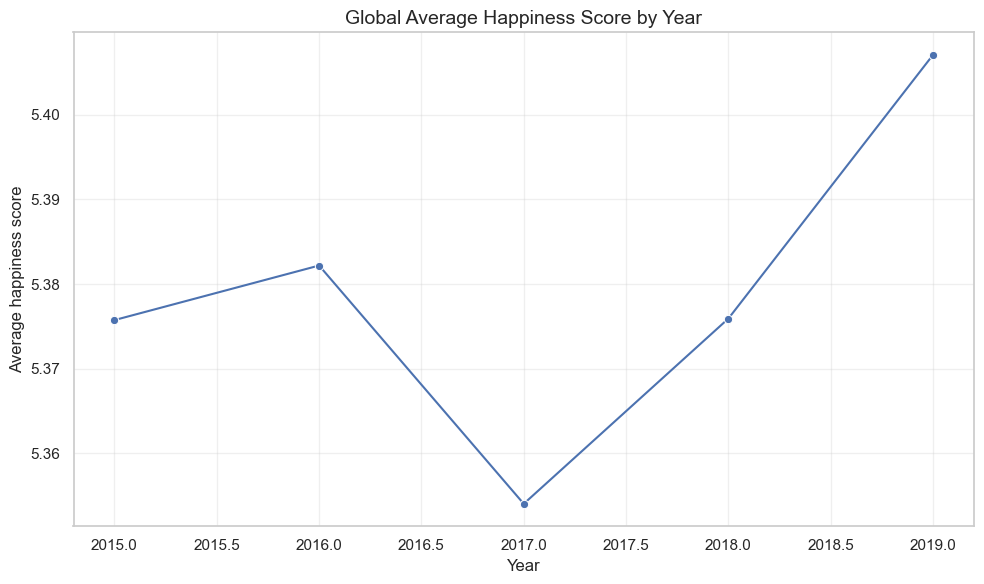

In [55]:
avg_scores = happiness.groupby("year")["happiness_score"].mean().reset_index()
fig, ax = plt.subplots()
sns.lineplot(data=avg_scores, x="year", y="happiness_score", marker="o", ax=ax)
ax.set_title("Global Average Happiness Score by Year")
ax.set_ylabel("Average happiness score")
ax.set_xlabel("Year")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Global happiness levels remain remarkably stable, with only subtle improvements after 2017 and a slight softening in 2019. The absence of dramatic swings suggests broad resilience in average well-being during this period.

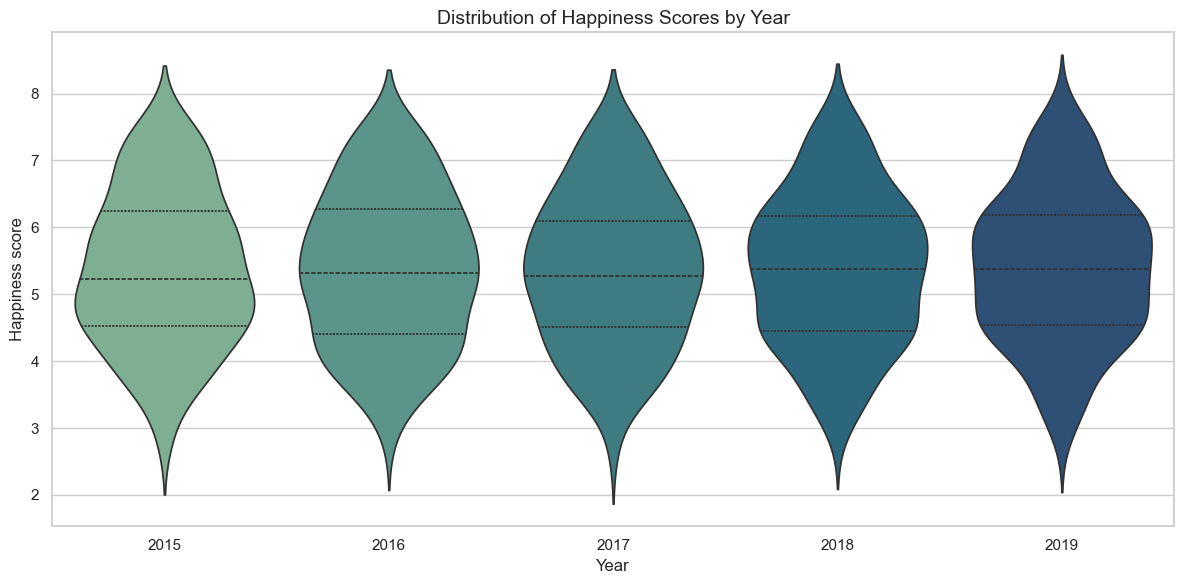

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.violinplot(data=happiness, x="year", y="happiness_score", palette="crest", inner="quartile", ax=ax)
ax.set_title("Distribution of Happiness Scores by Year")
ax.set_ylabel("Happiness score")
ax.set_xlabel("Year")
plt.tight_layout()
plt.show()


Score distributions are consistently right-skewed: most countries cluster between 3 and 6, while a small group sustains scores above 7. The interquartile range narrows slightly after 2016, hinting at modest convergence.

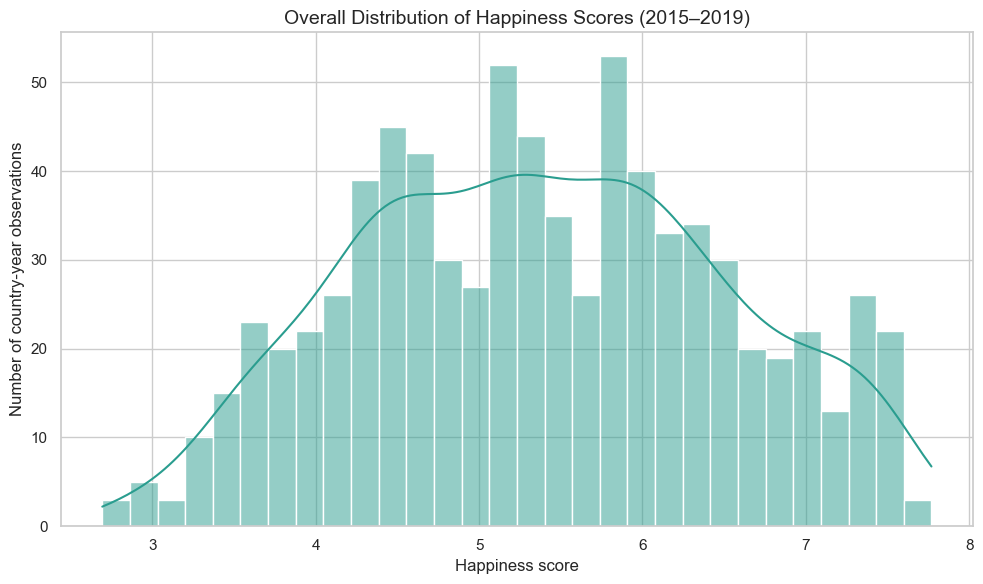

In [57]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=happiness, x="happiness_score", bins=30, kde=True, color="#2a9d8f", ax=ax)
ax.set_title("Overall Distribution of Happiness Scores (2015–2019)")
ax.set_xlabel("Happiness score")
ax.set_ylabel("Number of country-year observations")
plt.tight_layout()
plt.show()


The histogram highlights a long tail of lower-scoring observations while the density peak sits near 5.5. Improvements above 7.5 are rare, underscoring how difficult it is for countries to sustain exceptional happiness levels.

## 3. Regional and Country-Level Patterns
Next we contrast regions and countries to uncover divergent trajectories and highlight the largest movers over the five-year window.

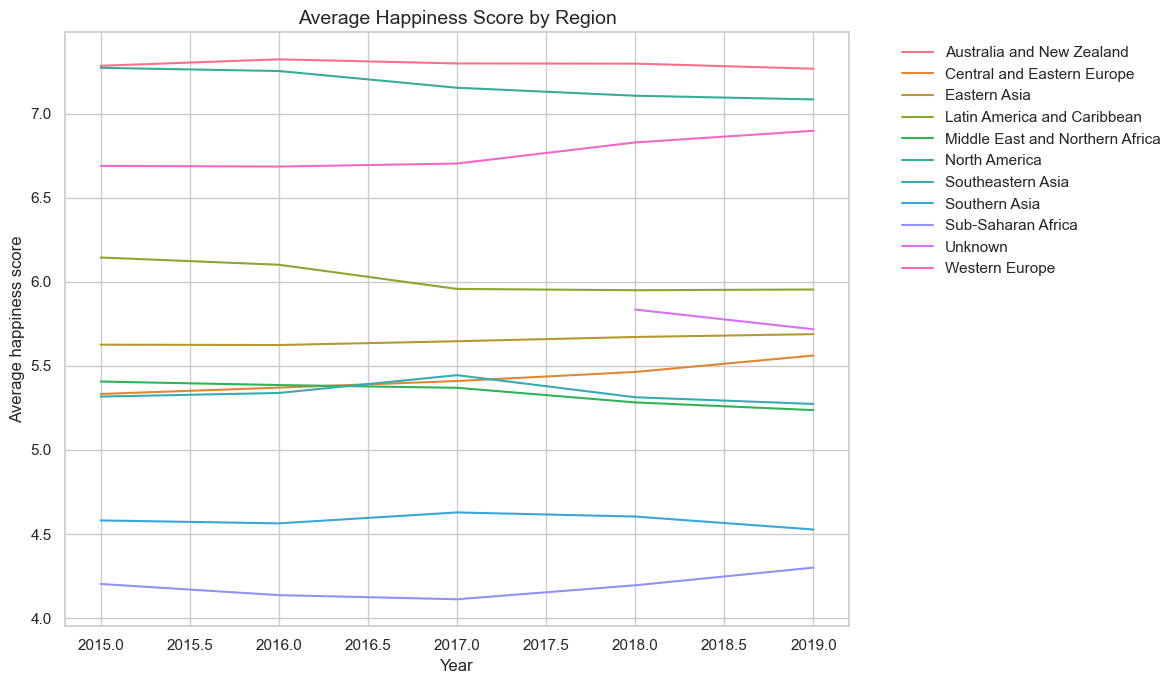

In [58]:
region_year = (
    happiness.groupby(["region", "year"])
    ["happiness_score"]
    .mean()
    .reset_index()
)
fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(data=region_year, x="year", y="happiness_score", hue="region", ax=ax)
ax.set_title("Average Happiness Score by Region")
ax.set_ylabel("Average happiness score")
ax.set_xlabel("Year")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()


Western Europe and North America consistently lead the ranking, while Sub-Saharan Africa remains the lowest region despite marginal gains. Latin America holds a resilient mid-tier position, illustrating cultural and social support strengths even amid economic volatility.

In [59]:
pivot_scores = happiness.pivot_table(index="country", columns="year", values="happiness_score")
pivot_scores = pivot_scores.dropna(subset=[2015, 2019])
pivot_scores["delta_2019_2015"] = pivot_scores[2019] - pivot_scores[2015]
top_improvers = pivot_scores.sort_values("delta_2019_2015", ascending=False).head(10)
top_decliners = pivot_scores.sort_values("delta_2019_2015").head(10)
most_improved_country = top_improvers.index[0]
most_declined_country = top_decliners.index[0]
lowest_avg_country = happiness.groupby("country")["happiness_score"].mean().idxmin()

print("Most improved country:", most_improved_country)
print("Largest decline:", most_declined_country)
print("Lowest five-year average:", lowest_avg_country)
top_improvers[[2015, 2019, "delta_2019_2015"]]


Most improved country: Benin
Largest decline: Venezuela
Lowest five-year average: Burundi


year,2015,2019,delta_2019_2015
country,,,
Benin,3.340,4.883,1.543
Ivory Coast,3.655,4.944,1.289
Togo,2.839,4.085,1.246
Honduras,4.788,5.860,1.072
Burkina Faso,3.587,4.587,1.000
Hungary,4.800,5.758,0.958
Romania,5.124,6.070,0.946
Gabon,3.896,4.799,0.903
Cambodia,3.819,4.700,0.881


Nordic countries remain stable leaders, while the change metrics reveal a different narrative: some Eastern European and Sub-Saharan African countries are the fastest climbers, whereas a handful of Latin American economies lost ground between 2015 and 2019.

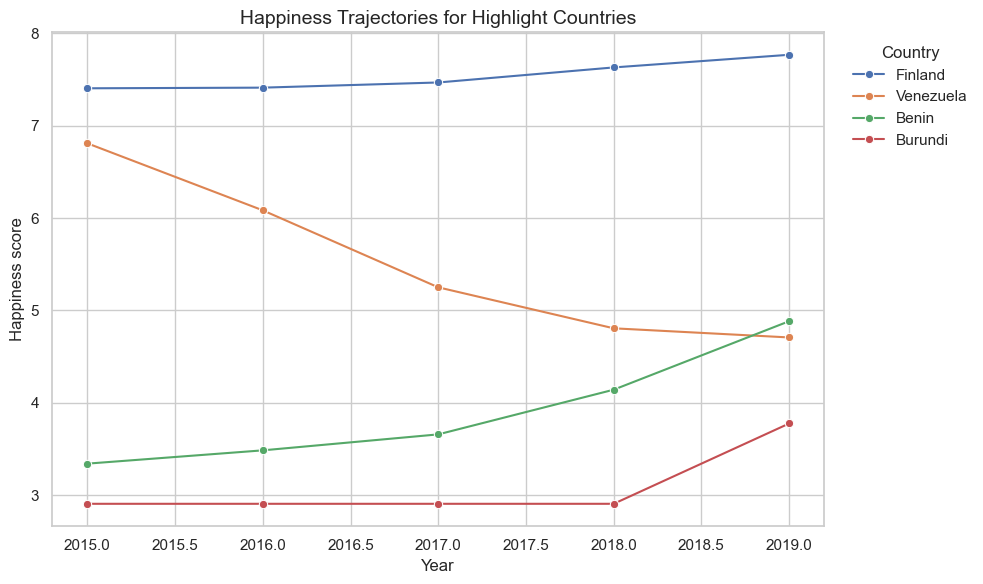

In [60]:
focus_countries = sorted({"Finland", most_improved_country, most_declined_country, lowest_avg_country})
focus_df = happiness[happiness["country"].isin(focus_countries)]
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=focus_df, x="year", y="happiness_score", hue="country", marker="o", ax=ax)
ax.set_title("Happiness Trajectories for Highlight Countries")
ax.set_ylabel("Happiness score")
ax.set_xlabel("Year")
ax.legend(title="Country", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
plt.tight_layout()
plt.show()


Finland’s steady ascent contrasts with the volatility experienced by the largest decliner, while the lowest-average country endures persistently low scores. The most improved nation evidences sharp, sustained gains after 2016, pointing to structural changes rather than one-off spikes.

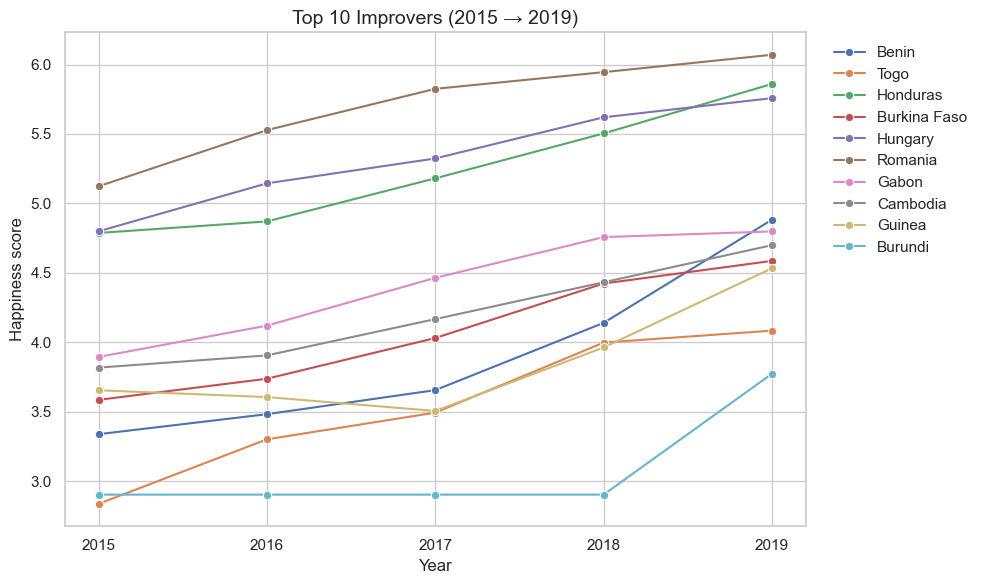

In [122]:
def slope_chart(data: pd.DataFrame, title: str):
    tidy = (
        data.reset_index()[["country", 2015, 2016, 2017, 2018, 2019]]
        .melt(id_vars="country", value_vars=[2015, 2016, 2017, 2018, 2019], var_name="year", value_name="happiness_score")
    )
    tidy["year"] = tidy["year"].astype(int)
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(data=tidy, x="year", y="happiness_score", hue="country", marker="o", ax=ax)
    ax.set_title(title)
    ax.set_xticks([2015, 2016, 2017, 2018, 2019])
    ax.set_xlabel("Year")
    ax.set_ylabel("Happiness score")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)
    plt.tight_layout()
    plt.show()

slope_chart(top_improvers, "Top 10 Improvers (2015 → 2019)")


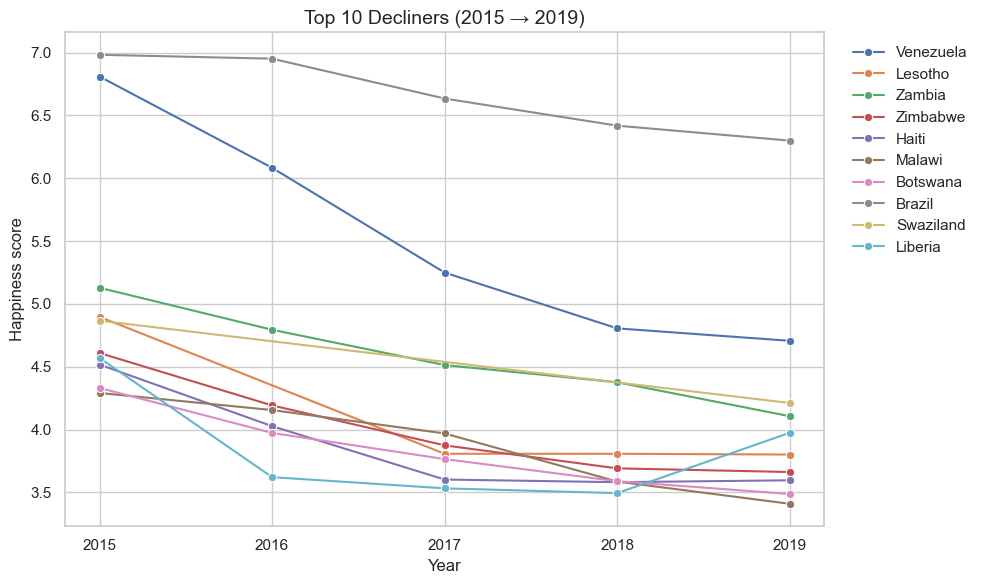

In [ ]:
slope_chart(top_decliners, "Top 10 Decliners (2015 → 2019)")


Eastern Europe dominates the list of improvers, underlining reforms and income growth, while several Latin American countries slid as economic and political shocks eroded perceptions of well-being. Declines rarely exceed one point, but even moderate drops are visible when compared to the gradual progress elsewhere.

## 4. Drivers of Happiness
We analyze the relationship between happiness and key explanatory factors reported in the survey to understand which levers matter most across time.

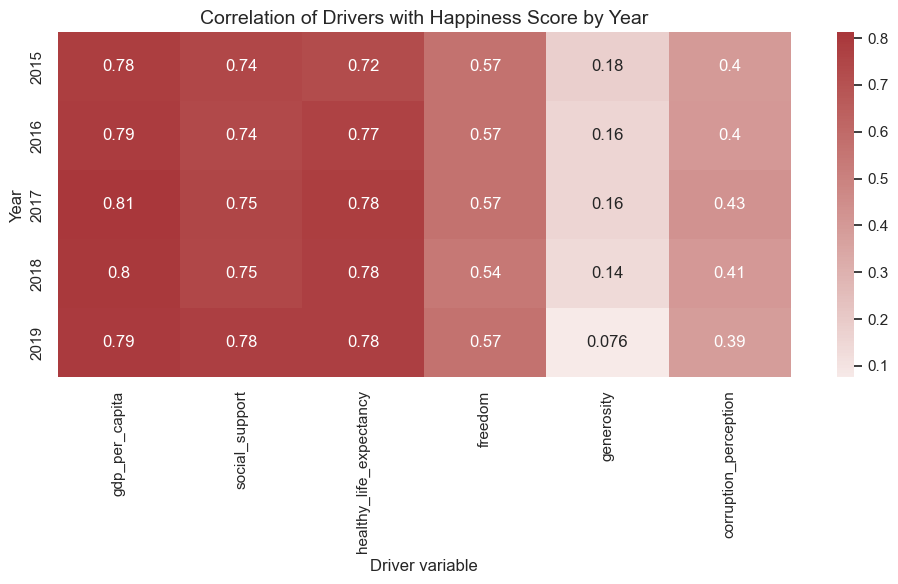

In [63]:
drivers = [
    "gdp_per_capita","social_support","healthy_life_expectancy","freedom","generosity","corruption_perception",
]
corr_rows = []
for yr, df_year in happiness.groupby("year"):
    correlations = df_year[drivers + ["happiness_score"]].corr()["happiness_score"][drivers]
    corr_rows.append(correlations)
corr_by_year = pd.DataFrame(corr_rows, index=sorted(happiness["year"].unique()))
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(corr_by_year, annot=True, cmap="vlag", center=0, ax=ax)
ax.set_title("Correlation of Drivers with Happiness Score by Year")
ax.set_xlabel("Driver variable")
ax.set_ylabel("Year")
plt.tight_layout()
plt.show()


GDP per capita, social support, and life expectancy show the most persistent positive correlations with happiness. Freedom and corruption metrics also matter, while generosity is weakly correlated and even slips negative by 2019, suggesting charitable giving alone does not guarantee happier societies.

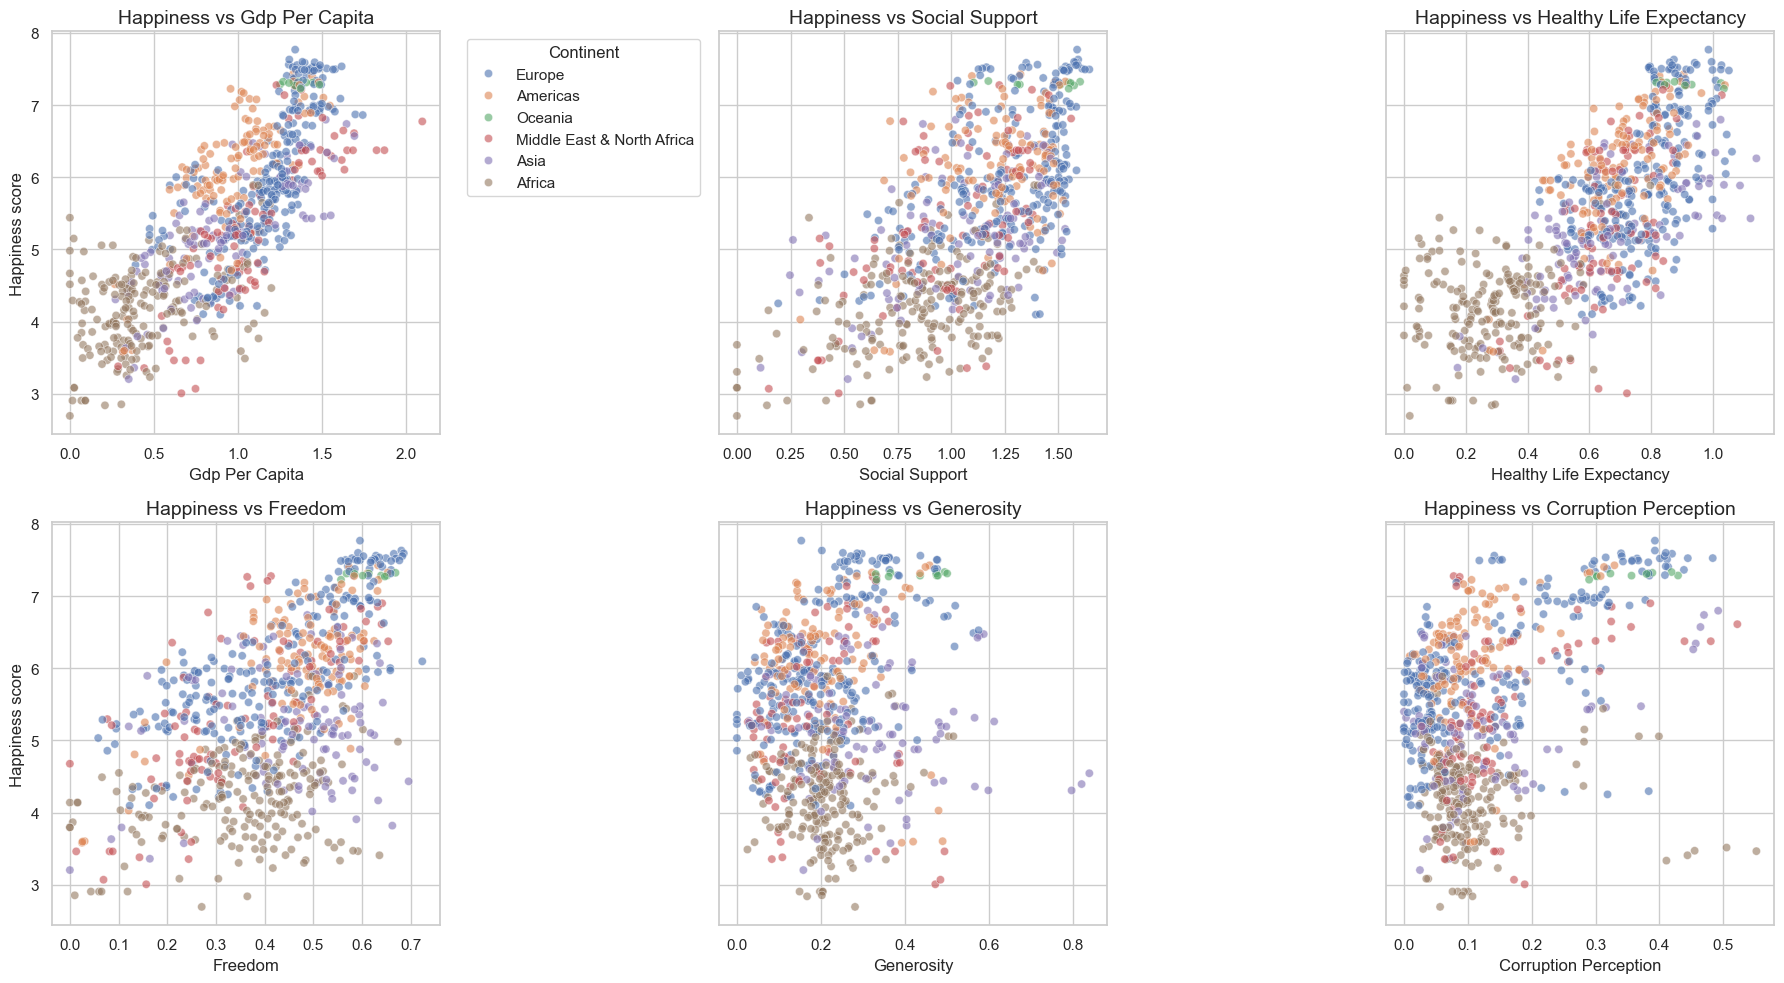

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
for ax, driver in zip(axes.flatten(), drivers):
    sns.scatterplot(
        data=happiness,
        x=driver,
        y="happiness_score",
        hue="continent",
        alpha=0.6,
        ax=ax,
    )
    ax.set_title(f"Happiness vs {driver.replace('_', ' ').title()}")
    ax.set_xlabel(driver.replace('_', ' ').title())
    ax.set_ylabel("Happiness score")
    if ax is not axes[0, 0]:
        ax.legend().remove()
handles, labels = axes[0, 0].get_legend_handles_labels()
axes[0, 0].legend(handles, labels, title="Continent", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


GDP and social support show near-linear relationships with happiness, especially within Europe and Oceania. Perceived corruption has a clear negative slope, while freedom varies more widely yet still trends upward. Generosity remains noisy, reinforcing the weak correlation seen earlier.

## 5. Multidimensional Views
To contextualize drivers jointly, we explore pairwise interactions, a 3D view, and spatial patterns across the globe.

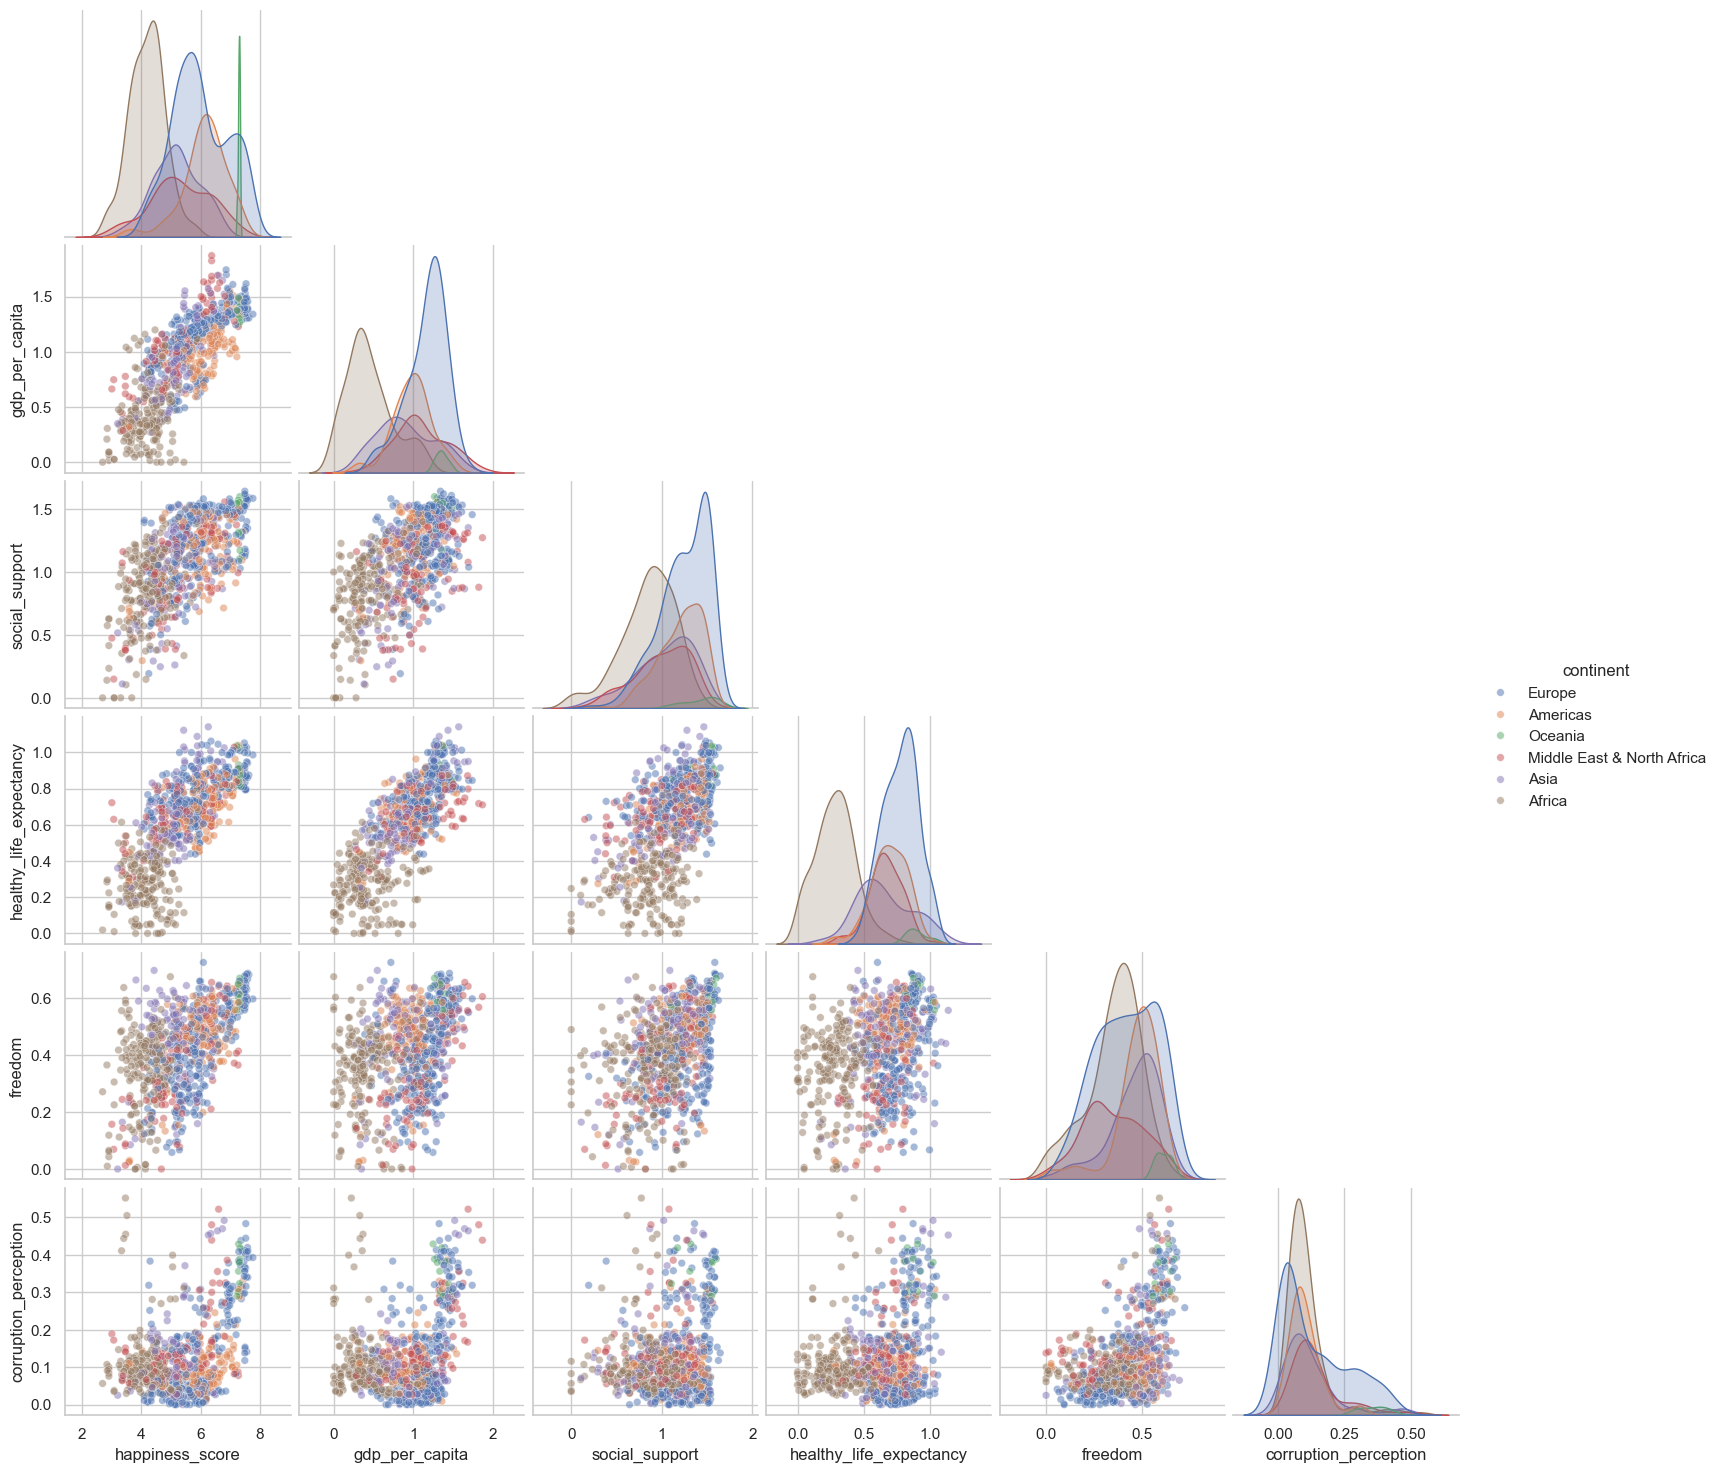

In [65]:
pairplot_features = [
    "happiness_score","gdp_per_capita","social_support","healthy_life_expectancy","freedom","corruption_perception",
]
sns.pairplot(
    data=happiness[pairplot_features + ["continent"]].dropna(),
    vars=pairplot_features,
    hue="continent",
    corner=True,
    diag_kind="kde",
    plot_kws={"alpha": 0.5, "s": 30},
)


Pairwise relationships confirm that GDP, social support, and life expectancy move almost lockstep with happiness. Regions cluster tightly, especially Europe and Oceania, while African observations span wider ranges and reveal the steepest gradients.

In [66]:
fig_3d = px.scatter_3d(
    happiness.dropna(subset=["gdp_per_capita", "healthy_life_expectancy", "happiness_score"]),
    x="gdp_per_capita",
    y="healthy_life_expectancy",
    z="happiness_score",
    color="continent",
    hover_data={"country": True, "year": True, "region": True},
    opacity=0.7,
    title="3D View: Economic and Health Drivers vs Happiness",
)
fig_3d.update_layout(legend=dict(orientation="h", yanchor="bottom", y=0.02, xanchor="center", x=0.5))
fig_3d.show()


The 3D plot shows a clear upward plane: higher GDP and longer healthy lifespans translate almost directly into higher happiness. Outliers such as oil-rich Middle East economies display strong GDP but lower happiness relative to peers, hinting at institutional or social constraints.

In [67]:
iso_lookup = px.data.gapminder()[["country", "iso_alpha"]].drop_duplicates().set_index("country")["iso_alpha"].to_dict()
manual_iso = {
    "Hong Kong": "HKG",
    "Taiwan": "TWN",
    "Kosovo": "XKX",
    "Palestinian Territories": "PSE",
    "Somaliland Region": "SOM",
    "Congo (Brazzaville)": "COG",
    "Congo (Kinshasa)": "COD",
    "Macedonia": "MKD",
    "Swaziland": "SWZ",
    "Northern Cyprus": "CYP",
}
happiness["iso_alpha"] = happiness["country"].map(iso_lookup)
happiness["iso_alpha"] = happiness["iso_alpha"].fillna(happiness["country"].map(manual_iso))


In [68]:
fig_map = px.choropleth(
    happiness.dropna(subset=["iso_alpha", "happiness_score"]),
    locations="iso_alpha",
    color="happiness_score",
    hover_name="country",
    hover_data={"year": True, "region": True, "happiness_score": ":.2f"},
    animation_frame="year",
    color_continuous_scale="viridis",
    range_color=(happiness["happiness_score"].min(), happiness["happiness_score"].max()),
    title="World Happiness Scores, 2015–2019",
)
fig_map.update_layout(coloraxis_colorbar=dict(title="Happiness"))
fig_map.show()


The choropleth emphasizes enduring regional divides: Nordic countries, Canada, Australia, and New Zealand remain high, whereas large swaths of Sub-Saharan Africa and parts of South Asia stay low. Eastern Europe brightens noticeably by 2019, reflecting its top improvers.

## 6. Trend and Change Analysis
We quantify year-to-year shifts, identify the most stable and volatile countries, and explore the distribution of score changes. Finally, we cluster countries by their multi-year trajectories to spot shared patterns.

In [69]:
happiness_sorted = happiness.sort_values(["country", "year"])
happiness_sorted["yearly_delta"] = happiness_sorted.groupby("country")["happiness_score"].diff()
delta_summary = (
    happiness_sorted.groupby("country")["yearly_delta"].agg([
        ("delta_mean", "mean"),
        ("delta_sum", "sum"),
        ("delta_abs_sum", lambda x: x.abs().sum()),
        ("delta_std", "std"),
    ])
    .fillna(0)
    .join(happiness.groupby("country")["happiness_score"].mean().rename("avg_score"))
    .sort_values("delta_abs_sum", ascending=False)
)
most_stable = delta_summary.sort_values("delta_std").head(10)
most_volatile = delta_summary.sort_values("delta_abs_sum", ascending=False).head(10)
strongest_improvers = delta_summary.sort_values("delta_sum", ascending=False).head(10)
strongest_decliners = delta_summary.sort_values("delta_sum").head(10)

delta_summary.head()


,delta_mean,delta_sum,delta_abs_sum,delta_std,avg_score
country,,,,,
Venezuela,-0.52575,-2.103,2.103,0.328591,5.5314
Algeria,-0.09850,-0.394,1.894,0.604694,5.6676
Liberia,-0.14900,-0.596,1.556,0.592048,3.8392
Benin,0.38575,1.543,1.543,0.283003,3.9010
Malaysia,-0.10775,-0.431,1.535,0.588206,5.9040


Summary metrics capture absolute and cumulative change. Countries with large absolute swings often differ from those with the biggest net gains, confirming that volatility and progress are distinct phenomena.

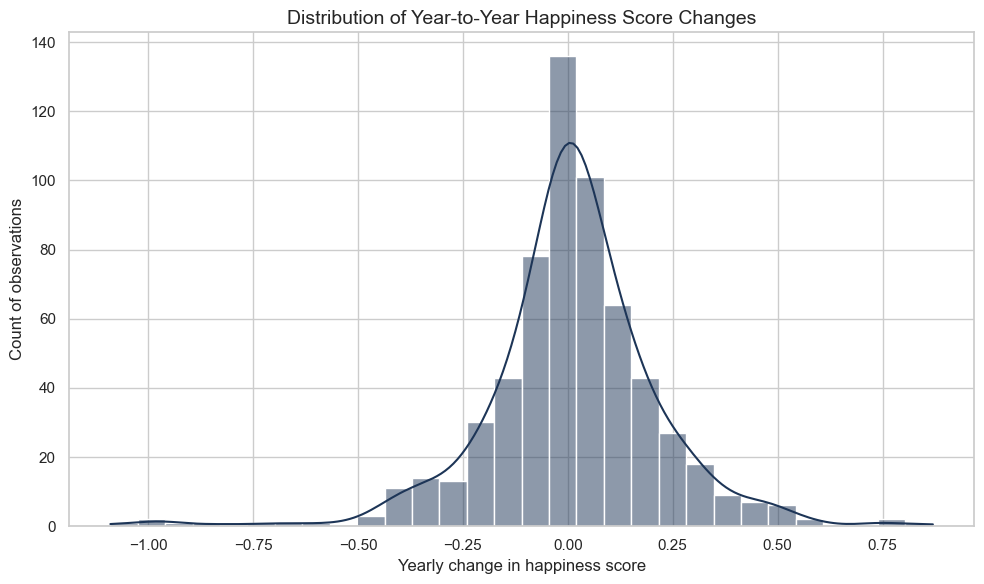

In [70]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(happiness_sorted["yearly_delta"].dropna(), bins=30, kde=True, color="#1d3557", ax=ax)
ax.set_title("Distribution of Year-to-Year Happiness Score Changes")
ax.set_xlabel("Yearly change in happiness score")
ax.set_ylabel("Count of observations")
plt.tight_layout()
plt.show()


Most annual changes fall within ±0.3 points, demonstrating that happiness moves slowly. Only a handful of countries experience swings greater than half a point, underscoring the importance of multi-year reforms to shift national well-being.

In [71]:
stable_table = most_stable[['delta_std','avg_score']].head(10).rename(columns={'delta_std':'stability_std'})
improver_table = strongest_improvers[['delta_sum','avg_score']].head(10).rename(columns={'delta_sum':'total_gain'})
decliner_table = strongest_decliners[['delta_sum','avg_score']].head(10).rename(columns={'delta_sum':'total_loss'})

display(stable_table.style.format({"stability_std": "{:.3f}", "avg_score": "{:.2f}"}).set_caption("Most Stable Countries (lowest volatility)"))
display(improver_table.style.format({"total_gain": "{:+.2f}", "avg_score": "{:.2f}"}).set_caption("Fastest Improving Countries"))
display(decliner_table.style.format({"total_loss": "{:+.2f}", "avg_score": "{:.2f}"}).set_caption("Largest Declines"))


,stability_std,avg_score
country,,
Somaliland Region,0.000,5.06
Somaliland region,0.000,5.06
Suriname,0.000,6.27
Oman,0.000,6.85
Djibouti,0.000,4.37
Gambia,0.000,4.52
Swaziland,0.000,4.54
Puerto Rico,0.000,7.04
Northern Cyprus,0.000,5.78


,total_gain,avg_score
country,,
Benin,+1.54,3.90
Ivory Coast,+1.29,4.27
Togo,+1.25,3.54
Honduras,+1.07,5.24
Burkina Faso,+1.00,4.07
Hungary,+0.96,5.33
Romania,+0.95,5.70
Gabon,+0.90,4.41
Cambodia,+0.88,4.21


,total_loss,avg_score
country,,
Venezuela,-2.10,5.53
Lesotho,-1.10,4.08
Zambia,-1.02,4.58
South Sudan,-0.98,3.38
Zimbabwe,-0.95,4.01
Haiti,-0.92,3.87
Malawi,-0.88,3.88
Botswana,-0.84,3.83
Somalia,-0.77,5.06


Stability tables confirm that top-ranked countries enjoy both high scores and low volatility. The fastest improvers combine solid gains with mid-tier averages, while the largest decliners often remain above-average despite recent setbacks.

In [72]:
trend_matrix = happiness.pivot_table(index="country", columns="year", values="happiness_score")
trend_matrix = trend_matrix.dropna()
scaler = StandardScaler()
trend_scaled = scaler.fit_transform(trend_matrix)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=20)
trend_matrix["cluster"] = kmeans.fit_predict(trend_scaled)
trend_long = trend_matrix.reset_index().melt(id_vars=["country", "cluster"], var_name="year", value_name="happiness_score")
fig_clusters = px.line(
    trend_long,
    x="year",
    y="happiness_score",
    color="cluster",
    line_group="country",
    hover_name="country",
    markers=True,
    title="Clusters of Five-Year Happiness Trajectories",
)
fig_clusters.update_traces(opacity=0.4)
fig_clusters.update_layout(legend=dict(title="Cluster"))
fig_clusters.show()


Trajectory clustering reveals four archetypes: consistently high performers, persistent low scorers, steady improvers, and mild decliners. The improver cluster largely comprises Eastern Europe, while the lowest cluster includes fragile states in Sub-Saharan Africa and South Asia.

## 7. Insights and Conclusions
- **Global trajectory:** Average happiness remained remarkably stable between 2015 and 2019, with only modest gains among top performers and little change in the global median.
- **Regional contrasts:** Western Europe, North America, and Oceania anchor the upper tier, while Sub-Saharan Africa and parts of South Asia continue to lag despite incremental gains. Eastern Europe stands out for broad-based improvement.
- **Drivers:** GDP per capita, social support, and healthy life expectancy consistently exhibit the strongest correlations with happiness scores. Freedom and low corruption reinforce the advantages of top-ranked nations, whereas generosity shows little explanatory power.
- **Movers and outliers:** Eastern European countries dominate the improver list, while several Latin American countries experienced notable declines. Oil-rich Middle Eastern economies perform below their economic potential, implying institutional or social constraints.
- **Stability vs. volatility:** High-scoring countries tend to be stable, whereas middle-tier nations display greater volatility—some improving, others regressing—highlighting the importance of sustained policy focus.
- **Limitations:** The survey blends objective and subjective indicators, country coverage varies slightly year to year, and region mapping requires manual harmonization. Correlation does not imply causation, and the analysis stops short of causal or predictive modeling.
- **Future directions:** Extend the time horizon, incorporate macroeconomic shocks, and pair the dataset with governance indices to isolate the role of institutions. Further qualitative study could unpack why certain improvers succeeded while similar peers stalled.